<a href="https://colab.research.google.com/github/yael-vinker/CLIPSketch/blob/main/CLIPSketch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***CLIPSketch*** - sketch your own image

Please note that the colab version is slower.
For faster sketching with multiprocessing please refer to the github repository and follow the running instructions.


**Define your target image**

You can upload your own target image to sketch, please put it under "CLIPSketch/target_images/".



## (1) Install Dependencies and Clone the Repo

Make sure your Hardware accelerator is set to GPU.

Runtime > Change runtime type > Hardware Accelerator 

In [4]:
# !git clone https://github.com/yael-vinker/CLIPSketch.git

import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/yael-vinker/CLIPSketch.git
%cd CLIPSketch
!pip install -r requirements.txt
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/BachiLi/diffvg
%cd diffvg
!git submodule update --init --recursive
!python setup.py install

GitHub user··········
GitHub password··········
fatal: destination path 'CLIPSketch' already exists and is not an empty directory.


In [9]:
device = torch.device("cuda" if (torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
def read_svg(path_svg, multiply=False):
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(path_svg)
    if multiply:
        canvas_width *= 2
        canvas_height *= 2
        for path in shapes:
            path.points *= 2
            path.stroke_width *= 2
    _render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(canvas_width, canvas_height, shapes, shape_groups)
    img = _render(canvas_width, # width
                canvas_height, # height
                2,   # num_samples_x
                2,   # num_samples_y
                0,   # seed
                None,
                *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = device) * (1 - img[:, :, 3:4])
    img = img[:, :, :3]
    return img


# (2) Start Sketching 🎨

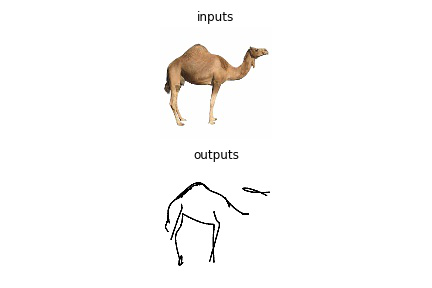

test epoch[800/801] loss[0.20310211181640625] time[0.2835118770599365]


<Figure size 432x288 with 0 Axes>

In [5]:
%cd /content/CLIPSketch

import subprocess as sp
import numpy as np
import os
import multiprocessing as mp
import warnings
import pydiffvg
import torch
import traceback
import logging

from torch.nn.parallel import parallel_apply
from shutil import copyfile
from PIL import Image
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.filterwarnings(action='once')

manager = mp.Manager()
exit_codes = []
losses_all = manager.dict()

if not os.path.isfile("/content/CLIPSketch/U2Net_/saved_models/u2net.pth"):
    sp.run(["gdown", "https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ", "-O", "U2Net_/saved_models/"])

test_name = "my_targets"
output_dir = f"/content/CLIPSketch/output_sketches/{test_name}/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

target_image = "camel.png" #@param {"type": "string"}
# ---@param {"type": "string"}
target_name = "camel" #@param {"type": "string"}

targets = [f"/content/CLIPSketch/target_images/{target_image}"]
target_names = [f"{target_name}"]
num_iter = 801
save_interval = 10
use_gpu=1
seeds = [100]

# if you need to mask the input image and pad the aspect ratio
fix_scale=0
mask_object=0
mask_object_attention=0

def run(target, seed, wandb_name):
    commands = ["python", "-W","ignore", "painterly_rendering.py", target, 
                                "--output_dir", output_dir,
                                "--wandb_name", wandb_name,
                                "--num_iter", str(num_iter),
                                "--save_interval", str(save_interval),
                                "--seed", str(seed),
                                "--use_gpu", str(use_gpu),
                                "--fix_scale", str(fix_scale), 
                                "--mask_object", str(mask_object),
                                "--mask_object_attention", str(mask_object_attention)]
    # proc = sp.Popen(commands)
    # try:
    #   outs, errs = proc.communicate(timeout=20000)
    # except Exception as e:
    #   logging.error(traceback.format_exc())
    %run painterly_rendering.py $target \
      --output_dir $output_dir \
      --wandb_name $wandb_name \
      --num_iter $num_iter \
      --save_interval $save_interval \
      --seed $seed \
      --use_gpu $use_gpu
    
    config = np.load(f"{output_dir}/{wandb_name}/config.npy", allow_pickle=True)[()]
    loss_eval = np.array(config['loss_eval'])
    inds = np.argsort(loss_eval)
    losses_all[wandb_name] = loss_eval[inds][0]

ncpus=10
# P = mp.Pool(ncpus) # Generate pool of workers
for target, target_name in zip(targets, target_names): # Generate processes
    for seed in seeds:
        wandb_name=f"{target_name}_seed{seed}"
        # P.apply_async(run,(target, seed, wandb_name)) # run simulation and ISF analysis in each process
        run(target, seed, wandb_name)

    # P.close()
    # P.join() # start processes 

    sorted_final = dict(sorted(losses_all.items(), key=lambda item: item[1]))
    path_best_svg = f"{output_dir}/{list(sorted_final.keys())[0]}/best_iter.svg"
    copyfile(path_best_svg, f"{output_dir}/{list(sorted_final.keys())[0]}_best.svg")
    # sketch = read_svg(path_best_svg, multiply=True).cpu().numpy()
    # sketch = Image.fromarray((sketch * 255).astype('uint8'), 'RGB')
    # plt.imshow(sketch)
    # plt.show()

# Display Results

In [10]:
#gifs for video
import imageio
import moviepy.editor as mvp
from subprocess import call
import os


path_res = f"{output_dir}"
for target in targets:
    for seed in seeds:
        sketches = []
        wandb_name=f"{target_name}_seed{seed}"
        cur_path = f"{path_res}/{wandb_name}"
        if os.path.exists(f"{cur_path}/config.npy"):
            config = np.load(f"{cur_path}/config.npy", allow_pickle=True)[()]
            inter = config["save_interval"]
            loss_eval = np.array(config['loss_eval'])
            inds = np.argsort(loss_eval)
            intervals = list(range(0, (inds[0] + 1) * inter,inter))
            for i_ in intervals:
                path_svg = f"{cur_path}/svg_iter{i_}.svg"
                sketch = read_svg(path_svg, multiply=True).cpu().numpy()
                sketch = Image.fromarray((sketch * 255).astype('uint8'), 'RGB')
                # print("{0}/iter_{1:04}.png".format(cur_path, int(i_)))
                sketch.save("{0}/iter_{1:04}.png".format(cur_path, int(i_)))
                sketches.append(sketch)
            imageio.mimsave(f"{cur_path}/sketch.gif", sketches)

            call(["ffmpeg", "-y", "-framerate", "10", "-pattern_type", "glob", "-i", 
                  f"{cur_path}/iter_*.png", "-vb", "20M",
                f"{cur_path}/sketch.mp4"])


            call(["ffmpeg", "-y", "-i", f"{cur_path}/sketch.mp4", "-filter_complex",
                "[0]trim=0:2[hold];[0][hold]concat[extended];[extended][0]overlay",
                f"{cur_path}/sketch_longer.mp4"])


    display(mvp.ipython_display(f"{cur_path}/sketch_longer.mp4"))
#     display(mvp.ipython_display(f"{cur_path}/out.mp4"))


/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0000.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0010.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0020.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0030.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0040.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0050.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0060.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0070.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0080.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0090.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0100.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0110.png
/content/CLIPSketch/output_sketches/my_targets//camel_seed100/iter_0120.png
/content/CLI

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [11]:
%cd /content/CLIPSketch/
!python general_test.py

/content/CLIPSketch
in main
results will be saved to output_sketches/camel/camel_seed0
cuda
{'target': 'target_images/camel.png', 'output_dir': 'output_sketches/camel/camel_seed0', 'path_svg': 'none', 'use_gpu': 1, 'seed': 0, 'mask_object': 0, 'fix_scale': 0, 'use_wandb': 0, 'wandb_user': 'yael-vinker', 'wandb_name': 'camel_seed0', 'wandb_project_name': 'none', 'num_iter': 2, 'num_stages': 1, 'lr_scheduler': 0, 'lr': 1.0, 'color_lr': 0.01, 'color_vars_threshold': 0.0, 'batch_size': 1, 'save_interval': 1, 'eval_interval': 10, 'image_scale': 224, 'num_paths': 16, 'width': 1.5, 'control_points_per_seg': 4, 'num_segments': 1, 'attention_init': 1, 'saliency_model': 'clip', 'saliency_clip_model': 'ViT-B/32', 'xdog_intersec': 1, 'mask_object_attention': 0, 'softmax_temp': 0.3, 'percep_loss': 'none', 'perceptual_weight': 0, 'train_with_clip': 0, 'clip_weight': 0, 'start_clip': 0, 'num_aug_clip': 4, 'include_target_in_aug': 0, 'augment_both': 1, 'augemntations': 'affine', 'noise_thresh': 0.5, '